In [880]:
import pandas as pd
#import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parse_results import *
from utils.utils import *
from db_utils.utils import *
from db_utils.query_storage import *
import networkx as nx
from cardinality_estimation.algs import *
import numpy as np
from cardinality_estimation.losses import *
#from cardinality_estimation.join_loss import JoinLoss, get_join_cost_sql, get_leading_hint
from cardinality_estimation.join_loss import *

from sql_rep.utils import nodes_to_sql, path_to_join_order
#from cvxopt import matrix, solvers
#import cvxopt
import cvxpy as cp
import time
import copy
# FIXME: separate jupyter utils files especially for plotting utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [881]:
def qerr(true, est):
    qerrs = []
    for k,y in true.items():
        yhat = est[k]
        qerrs.append(max( y / yhat, yhat / y))
    return sum(qerrs) / len(qerrs)

def eval_alg(sql, y, yhat, join_graph):
    print("qerr: ", qerr(y, yhat))
    est_costs, opt_costs, est_plans, opt_plans, est_sqls, opt_sqls = \
                env.compute_join_order_loss([sql], [join_graph],
                        [y], [yhat], None, True, num_processes=1, postgres=True, pool=None)
    print("jerr: {}".format(est_costs[0]-opt_costs[0]))
    plot_explain_join_order(est_plans[0], y, yhat, None, "Plan based on Estimates")
    plt.show()

    plot_explain_join_order(opt_plans[0], y, y, None, "Plan based on true values")
    plt.show()
    return opt_costs[0], opt_plans[0]

def plot_flow_path(edges, subsetg, solx, final_node, source_node):
    source_node = tuple("s")
    cur_node = final_node
    edge_dict = {}
    edge_widths = {}
    for i, e in enumerate(edges):
        edge_dict[e] = i
        edge_widths[e] = solx[i]

    all_edges = []
    best_path_nodes = []
    while True:
        out_edges = subsetg.out_edges(cur_node)
        min_cost_edge = None
        min_cost = -100000000000
    
        for edge in out_edges:
            idx = edge_dict[edge]
            wt = solx[idx]
            if wt > min_cost:
                min_cost_edge = edge
                min_cost = wt
        all_edges.append(min_cost_edge)
        best_path_nodes.append(cur_node)
        cur_node = min_cost_edge[1]
        all_edges.append(min_cost_edge)
        if cur_node == source_node:
            best_path_nodes.append(cur_node) 
            break

    print("going to draw flow path")
    draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths)
    

In [882]:
QUERY_DIR = "./our_dataset/queries/"
#query = "4a/4a10.pkl"
#query = "2a/2a300.pkl"
#query = "8a/8a141.pkl"
#query = "8a/8a91.pkl"
#query = "8a/8a127.pkl"
#query = "9a/b1be52459332af1a4f140611e0aa9037ac712eda.pkl"
#query = "11b/47e3b09c19496ff2d5817e5bc935ebb3e8379183.pkl"                                                         

#query = "1a/1a1835.pkl"
#query = "9b/7e37de327d93cc29605213bde97e8b0f1ebe1ecd.pkl"
#query = "2b/2b46.pkl"

## adding NON primary penalty fails for these
#query = "5a/5a749.pkl"

## works for nil8, but not nil9, ugh ughly
#query = "2b/2b238.pkl"

## fails for nil13 example
#query = "10a/1b7d9459de56e6c72e71cae1f55eb3b281602323.pkl"
#query = "2b/2b46.pkl"
query = "2a/2a308.pkl"


## shows improvement of 13, adding NON primary key index penalty
#query = "1a/1a1180.pkl"
#query = "2a/2a380.pkl"

## shows improvement of 13 over nli8
#query = "2a/2a308.pkl"

COST_MODEL = "nested_loop_index8"
COST_KEY = COST_MODEL + "cost"
#QUERY_DIR = "./debug_sqls/"
#query = "1.pkl"
#query = "2.pkl"

qfn = QUERY_DIR + query
postgres = Postgres()
true_alg = TrueCardinalities()

USER = "ubuntu"
PWD = ""
HOST = "localhost"
PORT = 5432
DB_NAME = "imdb"


# for join loss computations
env = JoinLoss(COST_MODEL, "ubuntu", "", "localhost", 5432, "imdb")

In [883]:
qrep = load_sql_rep(qfn)
join_graph = qrep["join_graph"]
subset_graph = qrep["subset_graph"]
sql = qrep["sql"]
print(sql)

SELECT COUNT(*) FROM title as t,
kind_type as kt,
info_type as it1,
movie_info as mi1,
movie_info as mi2,
info_type as it2,
cast_info as ci,
role_type as rt,
name as n,
movie_keyword as mk,
keyword as k
WHERE
t.id = ci.movie_id
AND t.id = mi1.movie_id
AND t.id = mi2.movie_id
AND t.id = mk.movie_id
AND k.id = mk.keyword_id
AND mi1.movie_id = mi2.movie_id
AND mi1.info_type_id = it1.id
AND mi2.info_type_id = it2.id
AND (it1.id in ('18'))
AND (it2.id in ('2'))
AND t.kind_id = kt.id
AND ci.person_id = n.id
AND ci.role_id = rt.id
AND (mi1.info in ('CBS Studio Center - 4024 Radford Avenue, Studio City, Los Angeles, California, USA','California, USA','France','Hamburg, Germany','Istanbul, Turkey','London, England, UK','Manhattan, New York City, New York, USA','Melbourne, Victoria, Australia','Montréal, Québec, Canada','Munich, Bavaria, Germany','San Diego, California, USA','Stage 37, Universal Studios - 100 Universal City Plaza, Universal City, California, USA','USA','Washington, District of C

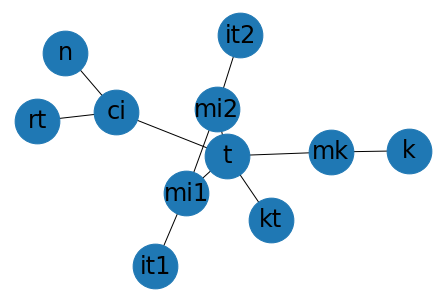

In [884]:
nx.draw(join_graph, pos=nx.spring_layout(join_graph), with_labels=True, node_size=2000, font_size=24)

qerr:  181.92609703516388
compute postgres join error took:  0.11275291442871094
jerr: 19361984.119999997


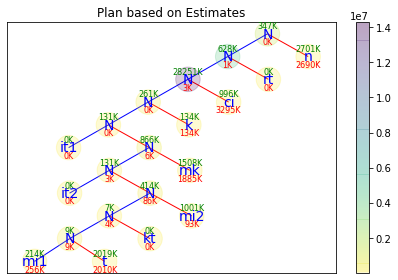

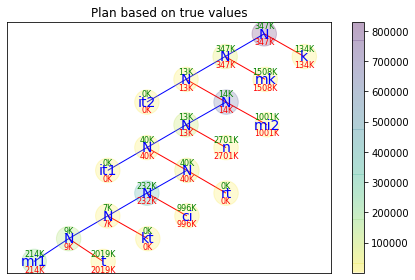

['Aggregate', 'Nested Loop', 'Nested Loop', 'Nested Loop', 'Seq Scan', 'Nested Loop', 'Nested Loop', 'Nested Loop', 'Seq Scan', 'Nested Loop', 'Nested Loop', 'Nested Loop', 'Nested Loop', 'Bitmap Heap Scan', 'Bitmap Index Scan', 'Index Scan', 'Index Scan', 'Index Scan', 'Index Scan', 'Index Scan', 'Index Scan', 'Index Scan', 'Index Only Scan']
[2377966.03, 2377098.19, 1548762.1, 1500182.69, 2.41, 1500037.78, 848035.29, 748092.02, 2.41, 747690.6, 711764.62, 330621.44, 329271.49, 195425.18, 12717.39, 4.78, 0.15, 54.33, 0.16, 2.5, 49.92, 3.37, 2.39]


In [885]:
y = true_alg.test([qrep])
y_pg = postgres.test([qrep])

random_alg = Random()
true_random = TrueRandom()
y_rand = random_alg.test([qrep])
y_true_rand = true_random.test([qrep])
sql = fix_query(sql)

opt_cost, opt_plan = eval_alg(sql, y[0], y_pg[0], join_graph)
node_types = extract_values(opt_plan[0][0], "Node Type")
costs = extract_values(opt_plan[0][0], "Total Cost")
print(node_types)
print(costs)
#print(opt_plan)

In [886]:
def dont_change_subset(k,v):
    ret = None
    #if "t" in k and "mi1" in k:
    if "ci" in k:
        ret = v
    else:
        ret = v + random.randint(-1000000,1000000)
    if ret <= 0:
        ret = 1
    return ret

def change_subset(k,v):
    ret = None
    # if "n" in k or "ci" in k:
    if "kt" in k and "t" in k and len(k) == 2:
       # ret = v -= random.randint(-100000,100000)
        ret = 10000
    #if "n" in k :
       # ret = random.randint(-100000,100000)
    #elif "rt" in k and "ci" in k and len(k) == 2:
        #ret = v * 1
    elif "rt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and len(k) == 3:
        ret = 108 * 1000
    elif "kt" in k and "ci" in k and "t" in k and "rt" in k and len(k) == 4:
        ret = 108 * 1000
    else:
        ret = v
        #ret = v + random.randint(-100,100)
    if ret <= 0:
        ret = 1
    return ret

def small_change(k,v):
    v += random.randint(-10000,10000)
    if v <= 0:
        v = 1
    return v
        
test_ests = {}
num_changed = 0
#for k,v in y[0].items():
for k,v in y_pg[0].items():
    test_ests[k] = change_subset(k,v)
    if test_ests[k] != v:
        num_changed += 1
        
print("total: {}, num changed: {}".format(len(y[0]), num_changed))
#eval_alg(sql, y[0], test_ests, join_graph)

total: 290, num changed: 4


In [887]:
subsetg = copy.deepcopy(qrep["subset_graph"])
add_single_node_edges(subsetg)
qrep["subset_graph_paths"] = subsetg
final_node = [n for n,d in subsetg.in_degree() if d==0][0]
source_node = tuple("s")
#draw_graph(subsetg)

In [888]:
COST_MODEL = "nested_loop_index13"

compute_costs(subsetg, COST_MODEL)
# we need to recalculate the weights here
path = nx.shortest_path(subsetg, final_node, source_node, weight=COST_MODEL + "cost")
#draw_graph(subsetg, highlight_nodes=path)

In [889]:
path = path[0:-1]
print(path)
join_order = [tuple(sorted(x)) for x in path_to_join_order(path)]
join_order.reverse()
sql_to_exec = nodes_to_sql(join_order, join_graph)
#sql_to_exec = sql_to_exec.replace("title as t CROSS JOIN kind_type as kt", "kind_type as kt CROSS JOIN title as t")
#print(sql_to_exec)
#sql_to_exec = fix_query(sql_to_exec)
print(sql_to_exec)

[('ci', 'it1', 'it2', 'k', 'kt', 'mi1', 'mi2', 'mk', 'n', 'rt', 't'), ('ci', 'it1', 'it2', 'kt', 'mi1', 'mi2', 'mk', 'n', 'rt', 't'), ('ci', 'it1', 'it2', 'kt', 'mi1', 'mi2', 'n', 'rt', 't'), ('ci', 'it1', 'kt', 'mi1', 'mi2', 'n', 'rt', 't'), ('ci', 'it1', 'kt', 'mi1', 'n', 'rt', 't'), ('ci', 'it1', 'kt', 'mi1', 'rt', 't'), ('ci', 'kt', 'mi1', 'rt', 't'), ('ci', 'kt', 'rt', 't'), ('ci', 'rt', 't'), ('ci', 'rt'), ('ci',)]
SELECT COUNT(*) FROM cast_info as ci CROSS JOIN role_type as rt CROSS JOIN title as t CROSS JOIN kind_type as kt CROSS JOIN movie_info as mi1 CROSS JOIN info_type as it1 CROSS JOIN name as n CROSS JOIN movie_info as mi2 CROSS JOIN info_type as it2 CROSS JOIN movie_keyword as mk CROSS JOIN keyword as k WHERE  (it1.id in ('18')) AND  (it2.id in ('2')) AND  (kt.kind in ('episode','movie','video movie')) AND  (mi1.info in ('CBS Studio Center - 4024 Radford Avenue, Studio City, Los Angeles, California, USA','California, USA','France','Hamburg, Germany','Istanbul, Turkey','L

In [890]:
cost_sql, est_cost, est_explain = get_join_cost_sql(sql_to_exec, y[0], join_graph, "ubuntu", "", "localhost", 5432, "imdb", 
                                                    COST_MODEL)
jerr = est_cost - opt_cost
jerr_ratio = est_cost / opt_cost
print("est_cost: {}, opt_cost: {}, jerr: {}, jerr_ratio: {}".format(est_cost, opt_cost, jerr, jerr_ratio))
extract_values(est_explain[0][0], "Node Type")
print(est_explain)
#print(cost_sql)


est_cost: 84387109.61, opt_cost: 2377966.03, jerr: 82009143.58, jerr_ratio: 35.487096344265275
[([{'Plan': {'Node Type': 'Aggregate', 'Strategy': 'Plain', 'Partial Mode': 'Simple', 'Parallel Aware': False, 'Startup Cost': 84387109.6, 'Total Cost': 84387109.61, 'Plan Rows': 1, 'Plan Width': 8, 'Plans': [{'Node Type': 'Nested Loop', 'Parent Relationship': 'Outer', 'Parallel Aware': False, 'Join Type': 'Inner', 'Startup Cost': 3.28, 'Total Cost': 84386241.78, 'Plan Rows': 347130, 'Plan Width': 0, 'Inner Unique': True, 'Plans': [{'Node Type': 'Nested Loop', 'Parent Relationship': 'Outer', 'Parallel Aware': False, 'Join Type': 'Inner', 'Startup Cost': 2.86, 'Total Cost': 83557905.69, 'Plan Rows': 347130, 'Plan Width': 4, 'Inner Unique': False, 'Plans': [{'Node Type': 'Nested Loop', 'Parent Relationship': 'Outer', 'Parallel Aware': False, 'Join Type': 'Inner', 'Startup Cost': 2.43, 'Total Cost': 83509326.28, 'Plan Rows': 12691, 'Plan Width': 16, 'Inner Unique': False, 'Plans': [{'Node Type':

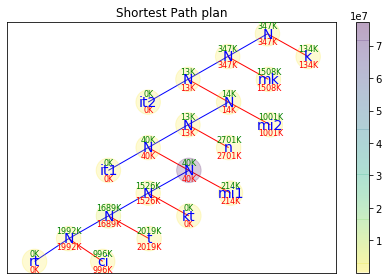

nested_loop_index13


In [891]:
plot_explain_join_order(est_explain, y[0], y[0], None, "Shortest Path plan")
plt.show()
print(COST_MODEL)

In [841]:
costs = extract_values(est_explain[0][0], "Total Cost")
node_types = extract_values(est_explain[0][0], "Node Type")

#print(len(costs))
print(node_types)
print(costs)

['Aggregate', 'Nested Loop', 'Nested Loop', 'Nested Loop', 'Seq Scan', 'Nested Loop', 'Nested Loop', 'Nested Loop', 'Nested Loop', 'Seq Scan', 'Nested Loop', 'Nested Loop', 'Nested Loop', 'Seq Scan', 'Index Scan', 'Index Scan', 'Index Scan', 'Index Scan', 'Seq Scan', 'Index Scan', 'Index Scan', 'Index Only Scan']
[92399650.65, 92398782.82, 91570446.73, 91521867.31, 2.41, 91521722.4, 90869719.91, 90853986.3, 90731357.23, 2.41, 90730865.23, 5331735.27, 415947.98, 1.15, 175024.01, 2.47, 50.55, 2.5, 1.1, 49.92, 3.37, 2.39]


In [444]:
edges, c, A, b, G, h = construct_lp(subsetg, cost_key=COST_KEY)

In [445]:
print(A.shape)
print("A rank: ", np.linalg.matrix_rank(A))
print(b)
nodes = list(subsetg.nodes())
nodes.sort()

(108, 295)
A rank:  107
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]


In [446]:
start = time.time()
n = len(edges)
x = cp.Variable(n)
constraints = [A @ x == b, G @ x <= 0]
prob = cp.Problem(cp.Minimize(c.T@x), constraints)
prob.solve(verbose=True)
print(prob.value)
print(x.value)
print("linear program took: ", time.time()-start)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.094e+07  +1.094e+07  +1e+08  7e-02  6e-01  1e+00  4e+05    ---    ---    1  1  - |  -  - 
 1  +5.093e+06  +5.409e+06  +9e+07  3e-01  5e-01  3e+05  3e+05  0.9890  8e-01   0  0  0 |  0  0
 2  -9.585e+06  -9.432e+06  +3e+07  3e-01  2e-01  2e+05  1e+05  0.7491  2e-01   0  0  0 |  0  0
 3  -1.274e+07  -1.270e+07  +1e+07  2e-01  5e-02  4e+04  4e+04  0.8051  2e-01   0  0  0 |  0  0
 4  -1.331e+07  -1.329e+07  +6e+06  2e-01  3e-02  1e+04  2e+04  0.9890  5e-01   0  0  0 |  0  0
 5  -1.250e+07  -1.249e+07  +2e+06  1e-01  9e-03  4e+03  7e+03  0.6952  8e-02   0  0  0 |  0  0
 6  -1.197e+07  -1.197e+07  +2e+06  1e-01  6e-03  2e+03  5e+03  0.9890  6e-01   0  0  0 |  0  0
 7  -1.077e+07  -1.077e+07  +6e+05  8e-02  2e-03  7e+02  2e+03  0.9890  3e-01   0  0  0 |  0  0
 8  -9.929e+06  -9.928e+06  +3e+05  7e-02  9e-

going to draw flow path


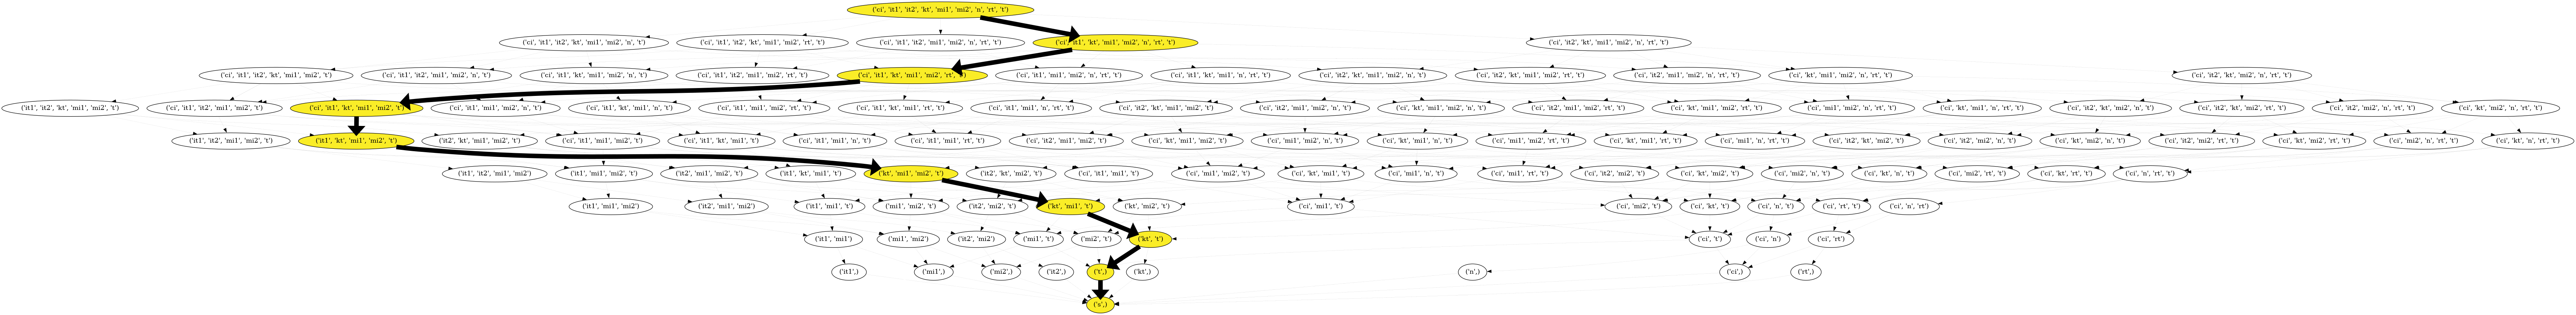

In [447]:
solx = np.array(x.value)
#draw_graph(subsetg, highlight_nodes=best_path_nodes, edge_widths=edge_widths)
plot_flow_path(edges, subsetg, solx, final_node, source_node)

In [457]:
edges, costs, A, b, G, h = construct_lp(subsetg, cost_key=COST_KEY)

n = len(edges)
P = np.zeros((len(edges),len(edges)))
for i,c in enumerate(costs):
    P[i,i] = c
    
q = np.zeros(len(edges))
x = cp.Variable(n)
#prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
#                 [G @ x <= h,
#                  A @ x == b])
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x),
                 [A @ x == b])
prob.solve(verbose=True)
qsolx = np.array(x.value)
print(qsolx)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 295, constraints m = 108
          nnz(P) + nnz(A) = 885
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   1.32e+04   1.00e-01   4.26e-04s
  50   4.1378e+03   9.34e-09   1.77e-07   1.00e-01   1.54e-03s
plsh   4.1378e+03   6.32e-15   2.36e-12   ---

going to draw flow path


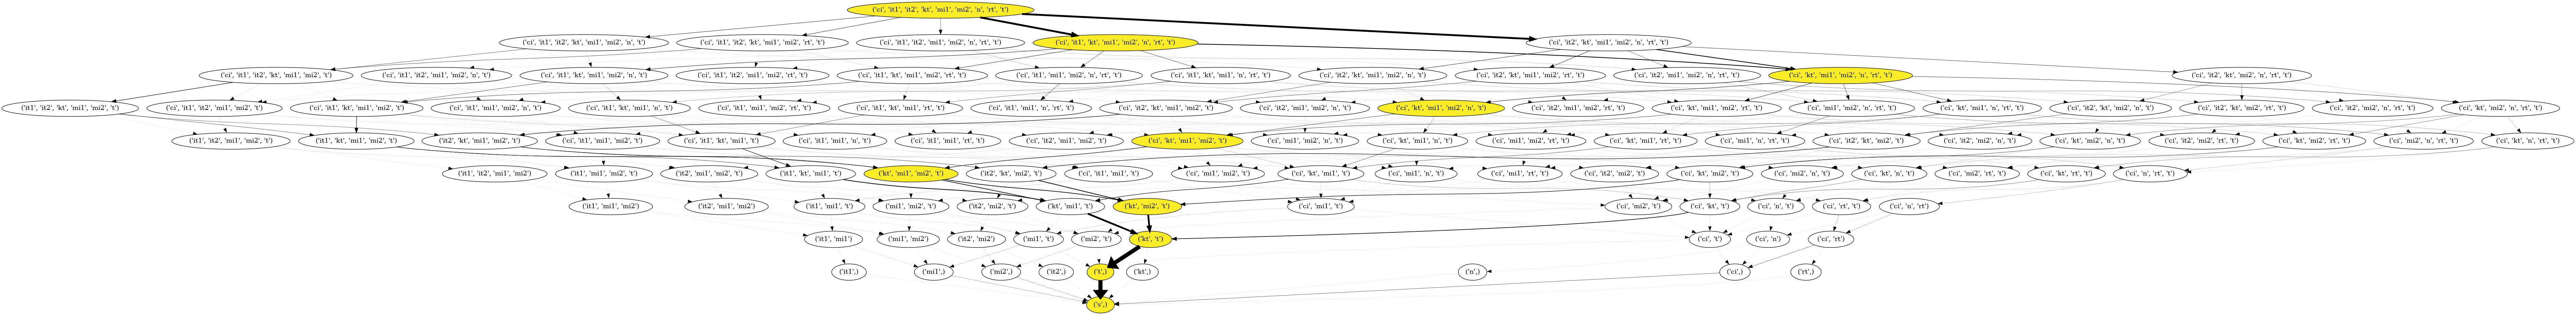

In [458]:
plot_flow_path(edges, subsetg, qsolx, final_node, source_node)

In [459]:
flow_cost, true_costs, Q2, G2, Gv2, v2, invG = debug_flow_loss(qrep, source_node, COST_KEY, COST_MODEL)
flows = Q2 @ v2
print(np.min(flows))
print(np.min(qsolx))

-0.03146528
-0.031465451411041706


In [451]:
print(np.allclose(costs, true_costs))
print(np.allclose(flows, qsolx))

print("actual solution off by a factor of 2")
print(prob.value*2)
print(flow_cost)

True
False
actual solution off by a factor of 2
8283.017887097829
8234.28


going to draw flow path


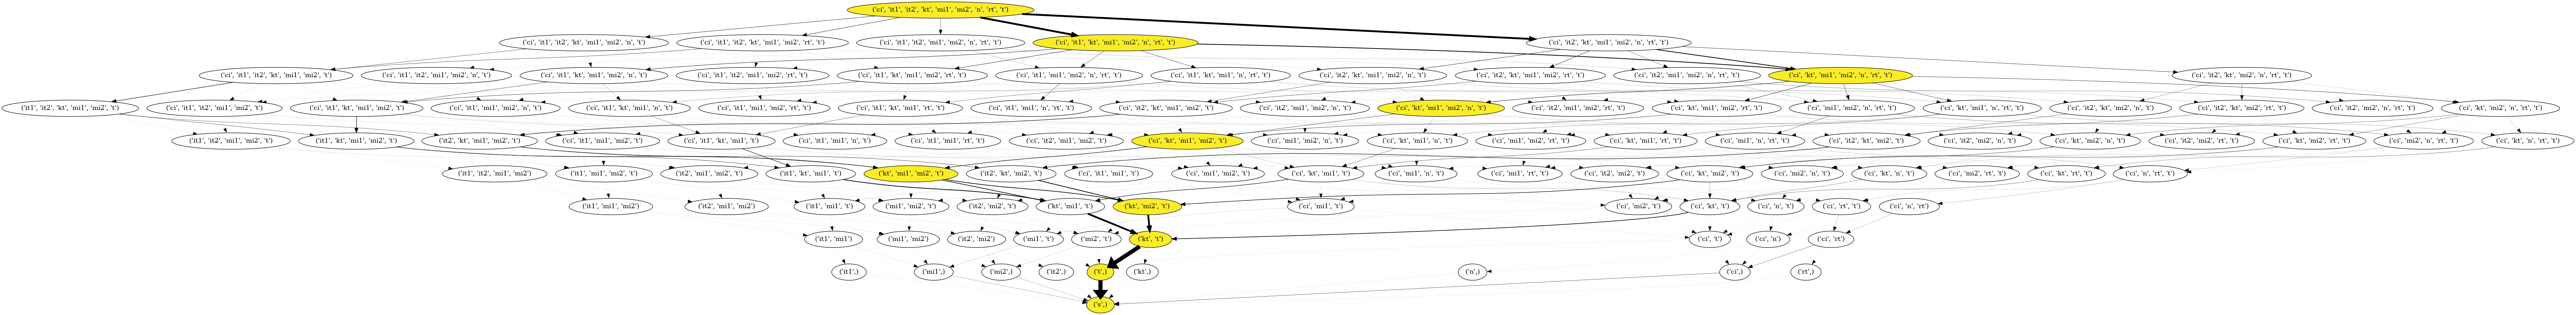

In [452]:
plot_flow_path(edges, subsetg, flows, final_node, source_node)

In [456]:
v2
np.mean(v2)

5827.691